In [1]:
import numpy as np
import pymultinest

import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib inline

import json

import corner

import retrieval_base.auxiliary_functions as af

def read_results(prefix, n_params):

    # Set-up analyzer object
    analyzer = pymultinest.Analyzer(
        n_params=n_params, 
        outputfiles_basename=prefix
        )
    stats = analyzer.get_stats()

    # Load the equally-weighted posterior distribution
    posterior = analyzer.get_equal_weighted_posterior()
    posterior = posterior[:,:-1]

    # Read the parameters of the best-fitting model
    bestfit = np.array(stats['modes'][0]['maximum a posterior'])

    PT = af.pickle_load(prefix+'data/bestfit_PT.pkl')
    Chem = af.pickle_load(prefix+'data/bestfit_Chem.pkl')

    m_spec = af.pickle_load(prefix+'data/bestfit_m_spec.pkl')
    d_spec = af.pickle_load(prefix+'data/d_spec.pkl')

    LogLike = af.pickle_load(prefix+'data/bestfit_LogLike.pkl')

    try:
        Cov = af.pickle_load(prefix+'data/bestfit_Cov.pkl')
    except:
        Cov = None

    int_contr_em           = np.load(prefix+'data/bestfit_int_contr_em.npy')
    int_contr_em_per_order = np.load(prefix+'data/bestfit_int_contr_em_per_order.npy')
    int_opa_cloud          = np.load(prefix+'data/bestfit_int_opa_cloud.npy')

    f = open(prefix+'data/bestfit.json')
    bestfit_params = json.load(f)
    f.close()

    print(posterior.shape)
    return posterior, bestfit, PT, Chem, int_contr_em, int_contr_em_per_order, int_opa_cloud, m_spec, d_spec, LogLike, Cov, bestfit_params

In [2]:
res = read_results(
    #prefix='./retrieval_outputs/order_6_ret_4/test_', n_params=36
    #prefix='./retrieval_outputs/fiducial_J_A_ret_1/test_', n_params=31
    prefix='./retrieval_outputs/fiducial_J_B_ret_1/test_', n_params=31
)
posterior, bestfit, PT, Chem, _, _, _, m_spec, d_spec, LogLike, _, bestfit_params = res


  analysing data from ./retrieval_outputs/fiducial_J_B_ret_1/test_.txt
(2646, 31)


In [3]:
from petitRADTRANS import Radtrans
import petitRADTRANS.nat_cst as nc
from PyAstronomy import pyasl
from scipy.ndimage import gaussian_filter, generic_filter

def opa_cross_sections(
        species, 
        species_mass, 
        T, 
        P, 
        epsilon_limb=0.4, 
        vsini=14, 
        rv=17.3, 
        #rv=-17.3, 
        out_res=5e4, 
        wlen_bords_micron=[(d_spec.wave.min()-5)/1e3,(d_spec.wave.max()+5)/1e3]
        #wlen_bords_micron=[1,2.5]
        ):
    pRT_atm = Radtrans(
        line_species=[species], wlen_bords_micron=wlen_bords_micron, mode='lbl'
        )
    res = pRT_atm.plot_opas(
        species=[species], temperature=T, pressure_bar=P, return_opacities=True
        )
    opa = res[species][1].flatten() * (species_mass*1.66053892e-24)

    wave = (nc.c / pRT_atm.freq * 1e7) 
    wave = wave * (1 + rv/(nc.c*1e-5))

    wave_even = np.linspace(wave.min(), wave.max(), wave.size)

    opa_even = np.interp(wave_even, xp=wave, fp=opa)
    opa_rot_broad = pyasl.fastRotBroad(
        wave_even, opa_even, epsilon=epsilon_limb, vsini=vsini
        )
    opa_rot_broad = instr_broadening(wave_even, opa_rot_broad, out_res=out_res, in_res=1e6)
    
    ###
    opa_rot_broad = opa_even
    ###
    
    return wave_even, opa_rot_broad

def instr_broadening(wave, flux, out_res=1e6, in_res=1e6):

    # Delta lambda of resolution element is FWHM of the LSF's standard deviation
    sigma_LSF = np.sqrt(1/out_res**2 - 1/in_res**2) / \
                (2*np.sqrt(2*np.log(2)))

    spacing = np.mean(2*np.diff(wave) / (wave[1:] + wave[:-1]))

    # Calculate the sigma to be used in the gauss filter in pixels
    sigma_LSF_gauss_filter = sigma_LSF / spacing
    
    # Apply gaussian filter to broaden with the spectral resolution
    flux_LSF = gaussian_filter(flux, sigma=sigma_LSF_gauss_filter, 
                                mode='nearest'
                                )
    return flux_LSF

In [27]:
fig, ax = plt.subplots(figsize=(12,4))
for i in range(d_spec.n_orders):
    for j in range(d_spec.n_dets):
        continue
        ax.plot(d_spec.wave[i,j,:], d_spec.flux[i,j,:] - LogLike.f[i,j]*m_spec.flux[i,j,:], c='k', lw=0.5)

ax_opa = ax.twinx()
#ax_opa.plot(
#    *opa_cross_sections(
#        'H2_12', species_mass=3, T=1200, P=1, 
#        ), 
#    lw=0.5, alpha=1
#    )
#ax_opa.plot(
#    *opa_cross_sections(
#        'H2_main_iso', species_mass=2, T=1200, P=1, 
#        ), 
#    lw=0.5, alpha=1
#    )

#ax_opa.plot(
#    *opa_cross_sections(
#        'Na_allard', species_mass=23, T=1200, P=1, 
#        ), 
#    lw=0.5, alpha=1
#    )

#ax_opa.plot(
#    *opa_cross_sections(
#        'Ti', species_mass=48, T=1200, P=1, 
#        ), 
#    lw=0.5, alpha=1
#    )

ax_opa.plot(
    *opa_cross_sections(
        'K', species_mass=39, T=1200, P=1, 
        #wlen_bords_micron=[0.6,1.3]
        wlen_bords_micron=[d_spec.wave.min()/1e3,d_spec.wave.max()/1e3], 
        #wlen_bords_micron=[d_spec.wave[5].min()/1e3,d_spec.wave[5].max()/1e3], 
        #wlen_bords_micron=[1.1,1.3]
        rv=0, vsini=1
        ), 
    lw=0.5, alpha=1
    )

#ax_opa.plot(
#    *opa_cross_sections(
#        'HDO_voronin', species_mass=19, T=1200, P=1, 
#        ), 
#    lw=0.5, alpha=1
#    )
#ax_opa.plot(
#    *opa_cross_sections(
#        'H2O_pokazatel_main_iso', species_mass=18, T=1200, P=1, 
#        ), 
#    lw=0.5, alpha=1
#    )
#ax_opa.plot(
#    *opa_cross_sections(
#        'H2O_main_iso', species_mass=18, T=1200, P=1, 
#        ), 
#    lw=0.5, alpha=1
#    )

#ax_opa.plot(
#    *opa_cross_sections(
#        'CO_36', species_mass=13.003355 + 15.999, T=1200, P=1, 
#        ), 
#    lw=0.5, alpha=1
#    )
#ax_opa.plot(
#    *opa_cross_sections(
#        'CO_28', species_mass=12.011 + 17.9991610, T=1200, P=1, 
#        ), 
#    lw=0.5, alpha=1
#    )
#ax_opa.plot(
#    *opa_cross_sections(
#        'CO_27', species_mass=12.011 + 16.999131, T=1200, P=1, 
#        ), 
#    lw=0.5, alpha=1
#    )

#ax_opa.plot(
#    *opa_cross_sections(
#        'NH3_coles_main_iso', species_mass=17, T=1200, P=1, 
#        ), 
#    lw=0.5, alpha=1
#    )

#ax_opa.plot(
#    *opa_cross_sections(
#        'CH4_hargreaves_main_iso', species_mass=16, T=1200, P=1, 
#        ), 
#    lw=0.5, alpha=1
#    )

#ax_opa.plot(
#    *opa_cross_sections(
#        'HCN_main_iso', species_mass=27, T=1200, P=1, 
#        ), 
#    lw=0.5, alpha=1
#    )

#ax_opa.plot(
#    *opa_cross_sections(
#        'H2S_main_iso', species_mass=34.082, T=1200, P=1, 
#        ), 
#    lw=0.5, alpha=1
#    )

#ax_opa.plot(
#    *opa_cross_sections(
#        'TiO_48_Exomol_McKemmish', species_mass=48, T=1200, P=1, 
#        ), 
#    lw=0.5, alpha=1
#    )

#ax_opa.plot(
#    *opa_cross_sections(
#        'Fe', species_mass=56, T=1500, P=1, 
#        ), 
#    lw=0.5, alpha=1
#    )
#ax_opa.plot(
#    *opa_cross_sections(
#        'FeH_main_iso', species_mass=57, T=1200, P=1, 
#        ), 
#    lw=0.5, alpha=1
#    )

#ax_opa.plot(
#    *opa_cross_sections(
#        'Ca', species_mass=40, T=1200, P=1, 
#        ), 
#    lw=0.5, alpha=1
#    )

#ax_opa.plot(
#    *opa_cross_sections(
#        'Li', species_mass=7, T=1200, P=1, 
#        ), 
#    lw=0.5, alpha=1
#    )

#ax_opa.plot(
#    *opa_cross_sections(
#        'OH_main_iso', species_mass=17, T=1200, P=1, 
#        ), 
#    lw=0.5, alpha=1
#    )

#ax.axvline(1243.2274*1.0000834254)
for line in [1.2436839, 1.2528860, 1.1692427, 1.1778406]:
    break
    ax_opa.axvline(line*1e3, c='C0')

for line in [1177.2861, 1177.6061, 1243.5675]:
    ax_opa.axvline(line, c='C1')

for line in [11690.21, 11769.62, 11772.83, 12432.24, 12522.11]:
    #ax_opa.axvline(line/10, c='C2')
    #ax_opa.axvline(line*1.0000834254/10, c='C2')
    ax_opa.axvline(line*1.0003/10, c='C2')

ax_opa.set(xlim=(1165,1180))
#ax_opa.set(xlim=(1240,1255))

#ax.set(xlim=(d_spec.wave[0].min(), d_spec.wave[0].max()))
#ax.set(xlim=(d_spec.wave[-3].min(), d_spec.wave[-3,1].max()))
ax_opa.set_yscale('log')
plt.savefig('./plots/opa_cross_sec.pdf')
#plt.show()
plt.close()

/home/sam/Documents/PhD/CRIRES_data_reduction/petitRADTRANS/petitRADTRANS/radtrans.py:113: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of K...
 Done.



In [ ]:
pRT_atm = Radtrans(
    line_species=['CO_12_HITEMP'], 
    #continuum_opacities=[], 
    wlen_bords_micron=[1.1,2.5], mode='c-k',
    )
pressures = np.logspace(-6, 2, 100)
pRT_atm.setup_opa_structure(pressures)

mass_fractions = {
    'H2': 0.75*np.ones_like(pressures), 
    'He': 0.25*np.ones_like(pressures), 
    'CO_12_HITEMP': 0*np.ones_like(pressures), 

    'H': 0.001*np.ones_like(pressures), 
    'H-': 5e-10*np.ones_like(pressures), 
    'e-': 2.1e-10*np.ones_like(pressures), 
    }

temperature = np.linspace(1100, 1300, 100)
MMW = 2.33 * np.ones_like(temperature)

gravity = 10**5

fig, ax = plt.subplots(figsize=(15,5))

pRT_atm.calc_flux(temperature, mass_fractions, gravity, MMW)
ax.plot(nc.c/pRT_atm.freq/1e-4, pRT_atm.flux/1e-6)

pRT_atm = Radtrans(
    line_species=['CO_12_HITEMP'], 
    continuum_opacities=['H2-H2'], 
    wlen_bords_micron=[1.1,2.5], mode='c-k',
    )
pressures = np.logspace(-6, 2, 100)
pRT_atm.setup_opa_structure(pressures)
pRT_atm.calc_flux(temperature, mass_fractions, gravity, MMW)
ax.plot(nc.c/pRT_atm.freq/1e-4, pRT_atm.flux/1e-6)

pRT_atm = Radtrans(
    line_species=['CO_12_HITEMP'], 
    continuum_opacities=['H2-He'], 
    wlen_bords_micron=[1.1,2.5], mode='c-k',
    )
pressures = np.logspace(-6, 2, 100)
pRT_atm.setup_opa_structure(pressures)
pRT_atm.calc_flux(temperature, mass_fractions, gravity, MMW)
ax.plot(nc.c/pRT_atm.freq/1e-4, pRT_atm.flux/1e-6)

pRT_atm = Radtrans(
    line_species=['CO_12_HITEMP'], 
    continuum_opacities=['H-'], 
    wlen_bords_micron=[1.1,2.5], mode='c-k',
    )
pressures = np.logspace(-6, 2, 100)
pRT_atm.setup_opa_structure(pressures)
pRT_atm.calc_flux(temperature, mass_fractions, gravity, MMW)
ax.plot(nc.c/pRT_atm.freq/1e-4, pRT_atm.flux/1e-6)

plt.show()


In [4]:
import numpy as np
import matplotlib.pyplot as plt

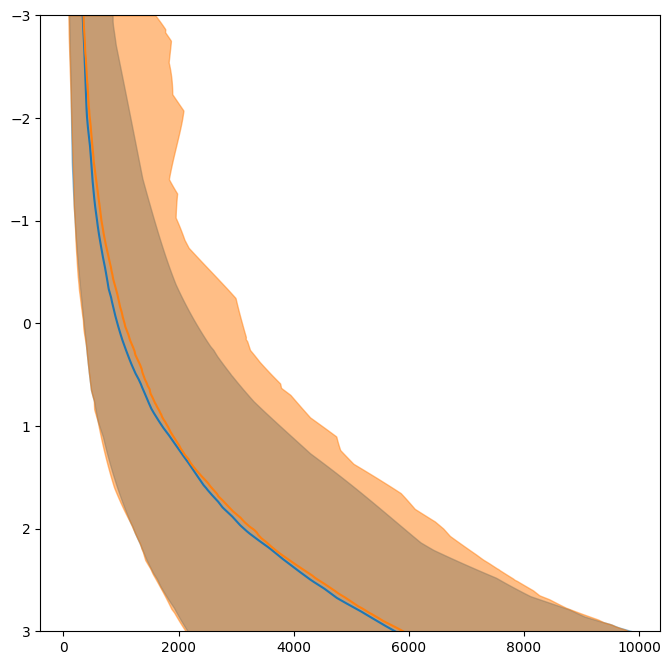

In [5]:
T_bottom = 3500
dlnT_dlnP = np.array([
    0.25,
    0.25, 
    0.26, 
    0.2, 
    0.12, 
    0.07
    ])

def temperature(T_bottom, dlnT_dlnP):
    
    log_P_knots = np.linspace(3,-3,6)
    log_P_array = np.linspace(3,-3,1000)
    from scipy.interpolate import interp1d
    f = interp1d(log_P_knots, dlnT_dlnP, kind='quadratic')
    dlnT_dlnP_array = f(log_P_array)

    T = [T_bottom]
    for i in range(len(dlnT_dlnP_array)-1):
        
        P_i1 = 10**log_P_array[i+1]
        P_i  = 10**log_P_array[i]

        T_i1 = np.exp(
            np.log(T[-1]) + (np.log(P_i1)-np.log(P_i)) * dlnT_dlnP_array[i]
        )
        T.append(T_i1)

    return np.array(T)

plt.figure(figsize=(8,8))
all_T = []
for _ in range(200):
    
    T_bottom = np.random.uniform(2000,10000)    
    dlnT_dlnP = np.array([
        np.random.normal(0.250,0.025), 
        np.random.normal(0.250,0.045), 
        np.random.normal(0.260,0.050), 
        np.random.normal(0.200,0.050), 
        np.random.normal(0.120,0.045), 
        np.random.normal(0.070,0.070), 
    ])

    T = temperature(T_bottom, dlnT_dlnP)
    all_T.append(T)
    #plt.plot(T, np.linspace(3,-3,1000), c='k', lw=1, alpha=0.2)

#plt.fill_betweenx(
#    y=np.linspace(3,-3,1000), 
#    x1=np.percentile(np.array(all_T), q=50-99.7/2, axis=0), 
#    x2=np.percentile(np.array(all_T), q=50+99.7/2, axis=0), 
#    alpha=0.5, color='C0'
#    )
plt.fill_betweenx(
    y=np.linspace(3,-3,1000), 
    x1=np.percentile(np.array(all_T), q=50-97/2, axis=0), 
    x2=np.percentile(np.array(all_T), q=50+97/2, axis=0), 
    alpha=0.5, color='C0'
    )
#plt.fill_betweenx(
#    y=np.linspace(3,-3,1000), 
#    x1=np.percentile(np.array(all_T), q=50-68/2, axis=0), 
#    x2=np.percentile(np.array(all_T), q=50+68/2, axis=0), 
#    alpha=0.5, color='C0'
#    )
plt.plot(np.percentile(np.array(all_T), q=50, axis=0), np.linspace(3,-3,1000))

for _ in range(200):
    
    T_bottom = np.random.uniform(2000,10000)    
    dlnT_dlnP = np.array([
        np.random.uniform(0.1,0.4), 
        np.random.uniform(0.1,0.4), 
        np.random.uniform(0.0,0.4), 
        np.random.uniform(0.0,0.4), 
        np.random.uniform(-0.1,0.4), 
        np.random.uniform(-0.1,0.4), 
    ])

    T = temperature(T_bottom, dlnT_dlnP)
    all_T.append(T)
    #plt.plot(T, np.linspace(3,-3,1000), c='k', lw=1, alpha=0.2)

#plt.fill_betweenx(
#    y=np.linspace(3,-3,1000), 
#    x1=np.percentile(np.array(all_T), q=50-99.7/2, axis=0), 
#    x2=np.percentile(np.array(all_T), q=50+99.7/2, axis=0), 
#    alpha=0.5, color='C0'
#    )
plt.fill_betweenx(
    y=np.linspace(3,-3,1000), 
    x1=np.percentile(np.array(all_T), q=50-97/2, axis=0), 
    x2=np.percentile(np.array(all_T), q=50+97/2, axis=0), 
    alpha=0.5, color='C1'
    )
#plt.fill_betweenx(
#    y=np.linspace(3,-3,1000), 
#    x1=np.percentile(np.array(all_T), q=50-68/2, axis=0), 
#    x2=np.percentile(np.array(all_T), q=50+68/2, axis=0), 
#    alpha=0.5, color='C0'
#    )
plt.plot(np.percentile(np.array(all_T), q=50, axis=0), np.linspace(3,-3,1000))

plt.ylim(3,-3)
plt.show()

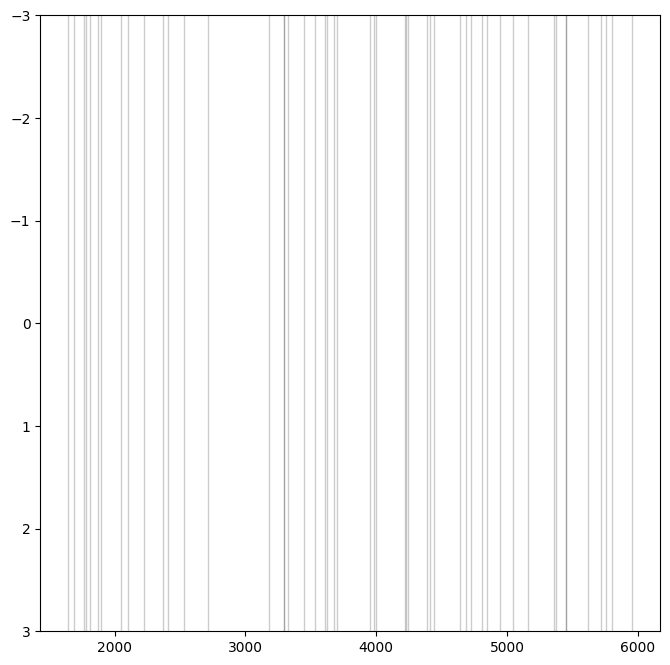

In [6]:
plt.figure(figsize=(8,8))
for _ in range(50):
    T_bottom = np.random.uniform(1500,6000)
    dlnT_dlnP = np.zeros(6)

    T = temperature(T_bottom, dlnT_dlnP)
    plt.plot(T, np.linspace(3,-3,1000), c='k', lw=1, alpha=0.2)
plt.ylim(3,-3)
plt.show()

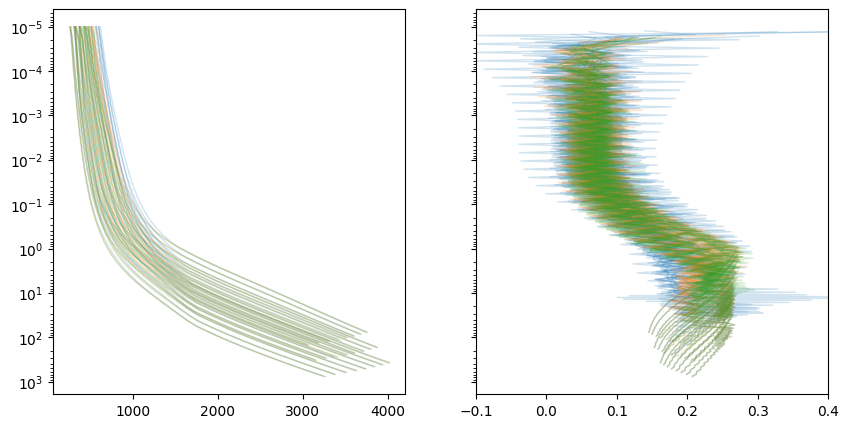

In [20]:
from scipy.interpolate import interp1d

#all_T_eff = np.concatenate((np.arange(200,600,50), np.arange(600,1800+1,100)))
all_T_eff = np.arange(200,3000+1,50)
all_log_g = np.arange(2.5,5.5+0.1,0.5)

all_T_eff = np.arange(1000,1700+1,50)
all_log_g = np.arange(4.5,5.5+0.1,0.5)

fig, ax = plt.subplots(figsize=(10,5), ncols=2, sharey=True)

#P_grid = 10**np.linspace(-5,2,50)
#P_grid = 10**np.linspace(-5,2,8)
#P_grid = 10**np.linspace(-5,2,6)
#P_grid = 10**np.linspace(-6,2,7)
#P_grid = 10**np.linspace(-6,2,12)
#P_grid = 10**np.linspace(-3,3,6)
P_grid = 10**np.array([-4, -2, -2/3, 2/3, 2])

#'''
T_grid = []
filename = '../ATMO_2020_models/CEQ_structures/pt_T{}_lg{:.1f}_CEQ.txt'
for T_eff in all_T_eff:
    for log_g in all_log_g:
        
        try:
            P, T = np.loadtxt(filename.format(T_eff, log_g)).T[[2,3]]
        except:
            continue
        
        dlnT_dlnP = np.diff(np.log(T))/np.diff(np.log(P))

        T_grid.append(
            interp1d(
                np.log10(P[1:]), dlnT_dlnP, 
                kind='quadratic', fill_value=np.nan, 
                bounds_error=False, 
                )(np.log10(P_grid))
        )

        ax[0].plot(T, P, c='C0', lw=1, alpha=0.2)
        ax[1].plot(dlnT_dlnP, P[1:], c='C0', lw=1, alpha=0.2)

#T_grid = []
filename = '../ATMO_2020_models/NEQ_weak_structures/pt_T{}_lg{:.1f}_NEQ_weak.txt'
for T_eff in all_T_eff:
    for log_g in all_log_g:
        
        try:
            P, T = np.loadtxt(filename.format(T_eff, log_g)).T[[2,3]]
        except:
            continue
        
        dlnT_dlnP = np.diff(np.log(T))/np.diff(np.log(P))

        T_grid.append(
            interp1d(
                np.log10(P[1:]), dlnT_dlnP, 
                kind='quadratic', fill_value=np.nan, 
                bounds_error=False, 
                )(np.log10(P_grid))
        )

        ax[0].plot(T, P, c='C1', lw=1, alpha=0.2)
        ax[1].plot(dlnT_dlnP, P[1:], c='C1', lw=1, alpha=0.2)
#'''

#T_grid = []
filename = '../ATMO_2020_models/NEQ_strong_structures/pt_T{}_lg{:.1f}_NEQ_strong.txt'
for T_eff in all_T_eff:
    for log_g in all_log_g:
        
        try:
            P, T = np.loadtxt(filename.format(T_eff, log_g)).T[[2,3]]
        except:
            continue
        
        dlnT_dlnP = np.diff(np.log(T))/np.diff(np.log(P))

        T_grid.append(
            interp1d(
                np.log10(P[1:]), dlnT_dlnP, 
                kind='quadratic', fill_value=np.nan, 
                bounds_error=False, 
                )(np.log10(P_grid))
        )

        ax[0].plot(T, P, c='C2', lw=1, alpha=0.2)
        ax[1].plot(dlnT_dlnP, P[1:], c='C2', lw=1, alpha=0.2)

ax[0].set(yscale='log')
ax[0].invert_yaxis()

ax[1].set(yscale='log', xlim=(-0.1,0.4))
#ax[1].invert_yaxis()

plt.show()

In [21]:
T_grid = np.array(T_grid)

mean, std = np.nanmean(T_grid, axis=0), np.nanstd(T_grid, axis=0)

In [35]:
print(np.vstack((mean-3*std, mean+3*std)).T[::-1])

[[ 0.12025008  0.28990025]
 [ 0.13489727  0.31540524]
 [ 0.03419113  0.23009758]
 [-0.00897898  0.13289389]
 [-0.02635933  0.12849026]]


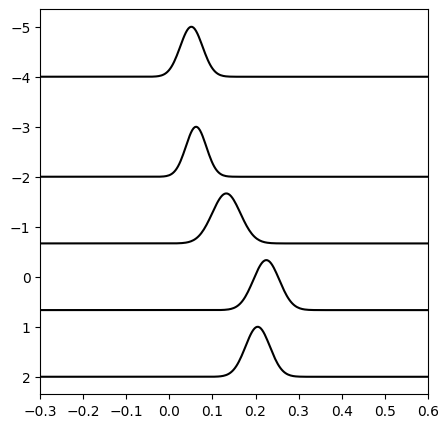

In [23]:
def gaussian(x, mu, sig):
    return np.exp(-np.power((x - mu) / sig, 2.0) / 2)

x = np.linspace(-0.5,1,500)

fig, ax = plt.subplots(figsize=(5,5))
for i in range(len(P_grid)):
    ax.plot(x, -1*gaussian(x,mean[i],std[i])+np.log10(P_grid[i]), c='k')

#ax.set(yscale='log')
ax.invert_yaxis()
#ax.set(xlim=(-0.12,0.43))
ax.set(xlim=(-0.3,0.6))
plt.show()

In [29]:
prior_dlnT_dlnP = [
    [(mean[i],std[i])] for i in range(len(mean))
    ]
print(np.array(prior_dlnT_dlnP)[:,0])

[[0.05106547 0.02580826]
 [0.06195745 0.02364548]
 [0.13214436 0.03265107]
 [0.22515126 0.03008466]
 [0.20507517 0.02827503]]


In [66]:
prior_dlnT_dlnP = [    
    [(0.07,0.07)], 
    [(0.12,0.045)], 
    [(0.2,0.05)], 
    [(0.26,0.05)],
    [(0.25,0.045)],
    [(0.25,0.025)],  
    ]

P_grid = 10**np.array([-6,-2,-2/3,2/3,2])
prior_dlnT_dlnP = np.array([    
    [(0.24,0.05)], 
    [(0.23,0.06)], 
    [(0.21,0.08)], 
    [(0.14,0.08)],
    [(0.12,0.09)],
    ])[::-1]

0.14 0.08


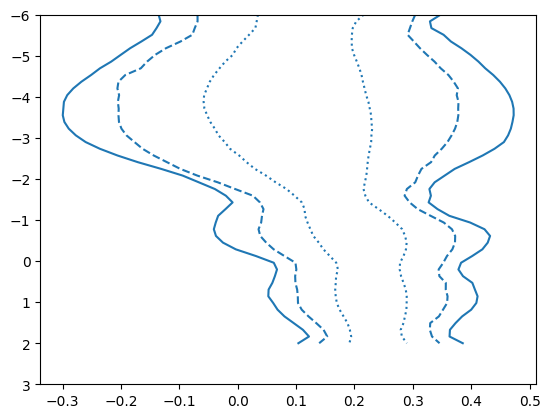

In [67]:
#prior_dlnT_dlnP = [
#    [(0.23840403,0.04608704), r'$\nabla_{T,0}$'],
#    [(0.23120480,0.06246088), r'$\nabla_{T,1}$'],
#    [(0.20749723,0.07635955), r'$\nabla_{T,2}$'],
#    [(0.13568251,0.07681570), r'$\nabla_{T,3}$'],
#    [(0.11589485,0.08800201), r'$\nabla_{T,4}$'],
#]

print(*prior_dlnT_dlnP[1][0])

dlnT_dlnP = np.array([
    np.random.normal(*prior_dlnT_dlnP[i][0], size=1000) \
    for i in range(len(prior_dlnT_dlnP))
    ])

pressures = 10**np.linspace(-6,2,50)

from scipy.interpolate import interp1d
dlnT_dlnP_array = []
for i in range(dlnT_dlnP.shape[1]):
    #f = interp1d(
    #    np.log10(P_grid)[np.isfinite(dlnT_dlnP[:,i])], 
    #    dlnT_dlnP[:,i][np.isfinite(dlnT_dlnP[:,i])], 
    #    kind='quadratic', fill_value=np.nan, bounds_error=False
    #    )
    #dlnT_dlnP_array.append(f(np.log10(pressures)))
    f = interp1d(
        np.log(P_grid)[np.isfinite(dlnT_dlnP[:,i])], 
        dlnT_dlnP[:,i][np.isfinite(dlnT_dlnP[:,i])], 
        kind='quadratic', fill_value=np.nan, bounds_error=False
        )
    dlnT_dlnP_array.append(f(np.log(pressures)))

q = 50 + np.array([-99.7,-97,-68,0,68,97,99.7])/2

dlnT_dlnP_quantiles = np.nanpercentile(dlnT_dlnP_array, q=q, axis=0)
#print(dlnT_dlnP_quantiles)
plt.plot(dlnT_dlnP_quantiles[0], np.log10(pressures), 'C0-')
plt.plot(dlnT_dlnP_quantiles[-1], np.log10(pressures), 'C0-')

plt.plot(dlnT_dlnP_quantiles[1], np.log10(pressures), 'C0--')
plt.plot(dlnT_dlnP_quantiles[-2], np.log10(pressures), 'C0--')

plt.plot(dlnT_dlnP_quantiles[2], np.log10(pressures), 'C0:')
plt.plot(dlnT_dlnP_quantiles[-3], np.log10(pressures), 'C0:')

plt.ylim(3,-6)
plt.show()

In [ ]:
print(np.log10(P_grid))

In [ ]:
print(mean)
print(std)

(100, 40)


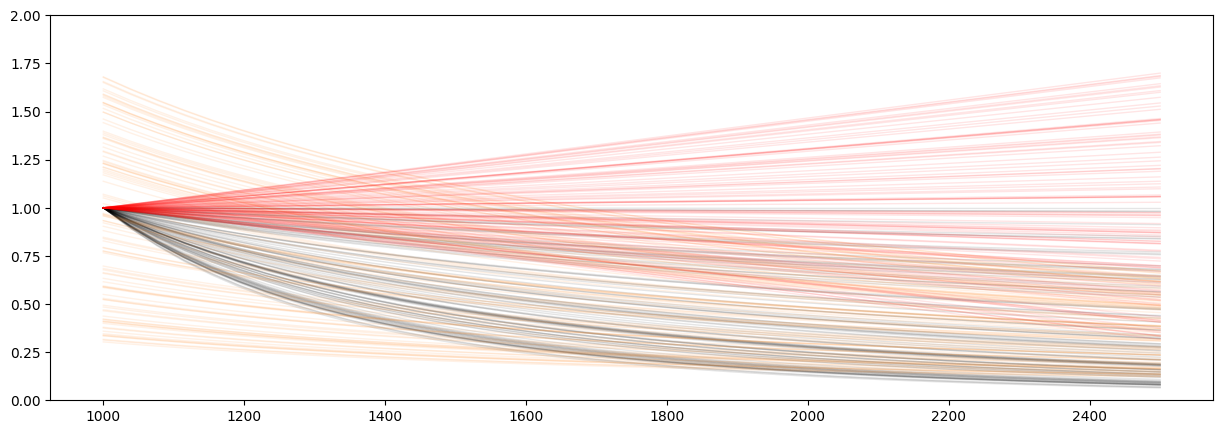

In [95]:
plt.figure(figsize=(15,5))

wave = np.linspace(1000,2500,40)
#cloud_slope = np.random.uniform(-10,10,size=100)
cloud_slope = np.random.uniform(-3,0,size=100)

kappa_wave = (wave[:,None]/1000)**cloud_slope[None,:]

for i in range(len(cloud_slope)):
    plt.plot(wave, kappa_wave[:,i], c='k', lw=1, alpha=0.1)


cloud_slope = np.random.uniform(0.3,1.7,size=100)

kappa_wave = (1000/wave[:,None])*cloud_slope[None,:]
for i in range(len(cloud_slope)):
    plt.plot(wave, kappa_wave[:,i], c='C1', lw=1, alpha=0.1)

cloud_slope = np.random.uniform(0.3,1.7,size=100)

kappa_wave = np.array([np.interp(wave, [1000,2500], [1,cloud_slope[i]]) for i in range(len(cloud_slope))])
print(kappa_wave.shape)

for i in range(len(cloud_slope)):
    plt.plot(wave, kappa_wave[i], c='r', lw=1, alpha=0.1)

plt.ylim(0,2)
plt.show()